### Culex Spectrogram Autoencoder & Feature Analysis

This notebook will guide you through:
1. Counting your spectrogram PNGs  
2. Training a convolutional autoencoder on `train/Culex`  
3. Slicing off the encoder and extracting latent features from **all** your PNGs  
4. Computing classic spectral descriptors directly from each PNG  
5. Visualizing descriptor relationships  
6. Clustering those descriptors with K-means and DBSCAN

Imports and global config


In [63]:
import os, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# spectrogram dimensions / sample rate / paths
IMG_H, IMG_W, IMG_C = 128, 128, 3
SR     = 100000        # sample rate used to generate these mel-spectrograms
N_MELS = 128
VMIN, VMAX = -80.0, 0.0

TRAIN_DIR  = "train/Culex"
TEST_DIR   = "test/Culex"
MODEL_DIR  = "models/Culex"
FEATURES_NPY = "features/Culex_features_all.npy"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs("features", exist_ok=True)

2) Count how many PNGs you have

In [64]:
train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.png")))
test_files  = sorted(glob.glob(os.path.join(TEST_DIR,  "*.png")))
print(f"Train/Culex: {len(train_files)} PNGs")
print(f"Test/Culex : {len(test_files)} PNGs")
print(f"Total       : {len(train_files)+len(test_files)} PNGs")

Train/Culex: 74 PNGs
Test/Culex : 22 PNGs
Total       : 96 PNGs


3) Define & train the autoencoder

In [65]:
def build_autoencoder(input_shape):
    inp = layers.Input(shape=input_shape, name="ae_in")
    x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = layers.MaxPool2D(2,padding='same')(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = layers.MaxPool2D(2,padding='same')(x)
    latent = layers.Conv2D(128,3,activation='relu',padding='same', name="latent")(x)
    x = layers.UpSampling2D(2)(latent)
    x = layers.Conv2DTranspose(64,3,activation='relu',padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(32,3,activation='relu',padding='same')(x)
    out = layers.Conv2D(input_shape[-1],3,activation='sigmoid',padding='same',name="ae_out")(x)
    ae = models.Model(inp, out, name="autoencoder")
    ae.compile(optimizer='adam', loss='mse')
    return ae

def make_dataset(path_list, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(path_list)
    if shuffle: ds = ds.shuffle(len(path_list))
    def _load(p):
        img = tf.io.read_file(p)
        img = tf.image.decode_png(img, channels=IMG_C)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return tf.image.resize(img, [IMG_H,IMG_W]), img
    return ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)\
             .batch(32).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_files, shuffle=True)
test_ds  = make_dataset(test_files,  shuffle=False)

ae = build_autoencoder((IMG_H,IMG_W,IMG_C))
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
ae.fit(train_ds, validation_data=test_ds, epochs=100, callbacks=[es], verbose=2)

ae.save(os.path.join(MODEL_DIR, "autoencoder.h5"))
print("Autoencoder saved.")

Epoch 1/100
3/3 - 2s - loss: 0.1813 - val_loss: 0.1003 - 2s/epoch - 696ms/step
Epoch 2/100
3/3 - 1s - loss: 0.0832 - val_loss: 0.0484 - 1s/epoch - 409ms/step
Epoch 3/100
3/3 - 1s - loss: 0.0444 - val_loss: 0.0308 - 857ms/epoch - 286ms/step
Epoch 4/100
3/3 - 1s - loss: 0.0298 - val_loss: 0.0208 - 845ms/epoch - 282ms/step
Epoch 5/100
3/3 - 1s - loss: 0.0193 - val_loss: 0.0170 - 870ms/epoch - 290ms/step
Epoch 6/100
3/3 - 1s - loss: 0.0152 - val_loss: 0.0152 - 864ms/epoch - 288ms/step
Epoch 7/100
3/3 - 1s - loss: 0.0164 - val_loss: 0.0164 - 873ms/epoch - 291ms/step
Epoch 8/100
3/3 - 1s - loss: 0.0157 - val_loss: 0.0134 - 872ms/epoch - 291ms/step
Epoch 9/100
3/3 - 1s - loss: 0.0139 - val_loss: 0.0129 - 882ms/epoch - 294ms/step
Epoch 10/100
3/3 - 1s - loss: 0.0122 - val_loss: 0.0107 - 875ms/epoch - 292ms/step
Epoch 11/100
3/3 - 1s - loss: 0.0108 - val_loss: 0.0091 - 859ms/epoch - 286ms/step
Epoch 12/100
3/3 - 1s - loss: 0.0095 - val_loss: 0.0093 - 860ms/epoch - 287ms/step
Epoch 13/100
3/3 - 

4) Slice off the encoder & save it

In [66]:
encoder = models.Model(
    inputs=ae.input,
    outputs=ae.get_layer("latent").output,
    name="encoder"
)
encoder.save(os.path.join(MODEL_DIR, "encoder.h5"))
print("Encoder saved.")

Encoder saved.


5) Extract latent features from **all** PNGs

In [67]:
all_files = sorted(train_files + test_files)
print(f"Extracting from {len(all_files)} total PNGs…")

ds_all = tf.data.Dataset.from_tensor_slices(all_files)
def _load_img(p):
    img = tf.io.read_file(p)
    img = tf.image.decode_png(img, channels=IMG_C)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_H,IMG_W])
ds_all = ds_all.map(_load_img, num_parallel_calls=tf.data.AUTOTUNE)\
               .batch(32).prefetch(tf.data.AUTOTUNE)

latents = encoder.predict(ds_all, verbose=1)        # shape (N, H', W', C')
N,Hp,Wp,Cp = latents.shape
features = latents.reshape(N, Hp*Wp*Cp)             # (N, D)
np.save(FEATURES_NPY, features)
print(f"Features saved to {FEATURES_NPY} (shape {features.shape})")


Extracting from 96 total PNGs…
3/3 [==============================] - 0s 22ms/step
Features saved to features/Culex_features_all.npy (shape (96, 131072))


6) Compute hand-crafted spectral descriptors


In [68]:
def load_log_mel(path):
    img = Image.open(path).convert('L')
    arr = np.array(img, np.float32)/255.0
    return arr*(VMAX-VMIN)+VMIN

def compute_desc(log_S):
    S = librosa.db_to_power(log_S)
    mel_f = librosa.mel_frequencies(n_mels=N_MELS, fmin=0, fmax=SR/2)
    c  = librosa.feature.spectral_centroid(S=S, sr=SR, freq=mel_f)[0]
    b  = librosa.feature.spectral_bandwidth(S=S, sr=SR, freq=mel_f)[0]
    r  = librosa.feature.spectral_rolloff(S=S, sr=SR, roll_percent=0.85)[0]
    z  = librosa.feature.zero_crossing_rate(librosa.db_to_power(log_S))[0]
    return {
        "centroid_mean":   c.mean(),
        "centroid_std":    c.std(),
        "bandwidth_mean":  b.mean(),
        "rolloff_mean":    r.mean(),
        "zcr_mean":        z.mean(),
    }

records = []
for p in all_files:
    logS = load_log_mel(p)
    desc = compute_desc(logS)
    desc["filename"] = os.path.basename(p)
    records.append(desc)
df = pd.DataFrame(records).set_index("filename")
print(df)


                                                    centroid_mean  \
filename                                                            
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection...    8252.361177   
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection...    8298.875240   
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection...    8593.869872   
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection...    8033.943220   
2025_04_03_NI_Cxpp_male_mosq1_-30V_No injection...    7826.537282   
...                                                           ...   
2025_04_04_NI_Cxpp_male_mosq3_-30V_No injection...    7224.909850   
2025_04_04_NI_Cxpp_male_mosq3_-30V_No injection...    7154.288141   
2025_04_04_NI_Cxpp_male_mosq3_-30V_No injection...    7287.708954   
2025_04_04_NI_Cxpp_male_mosq3_-30V_No injection...    7264.559947   
2025_04_04_NI_Cxpp_male_mosq3_-30V_No injection...    7173.870894   

                                                    centroid_std  \
filename                          

7) Visualize descriptor relationships

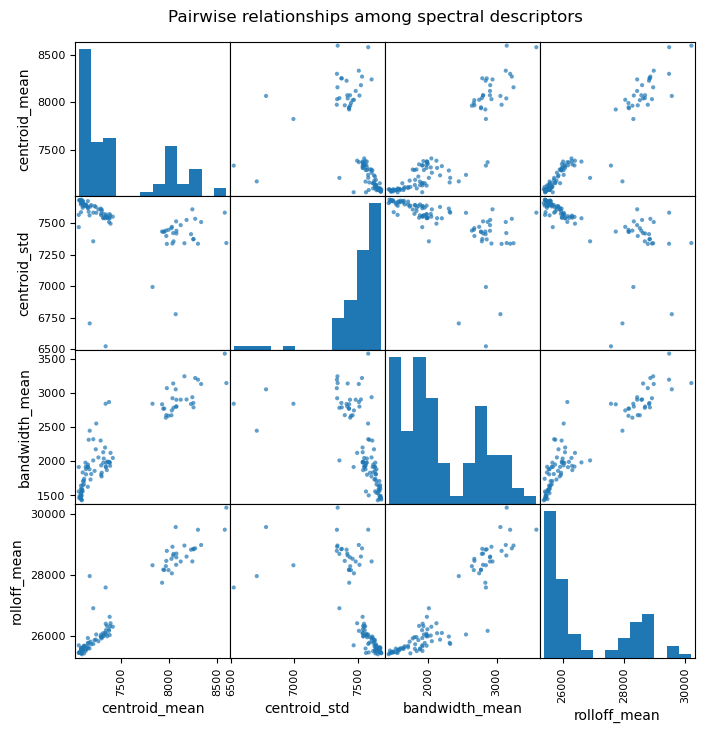

In [69]:
df_var = df.loc[:, df.std()>0]
pd.plotting.scatter_matrix(
    df_var, figsize=(8,8), diagonal="hist", hist_kwds={"bins":12}, alpha=0.7
)
plt.suptitle("Pairwise relationships among spectral descriptors", y=0.92)
plt.show()

8) Cluster your descriptors

K-means silhouette scores:
  k=2: 0.715
  k=3: 0.738
  k=4: 0.640
  k=5: 0.470

Cluster counts (k=3):
km3
0    65
1    27
2     4
Name: count, dtype: int64


c:\Users\alber\anaconda3\envs\CNN_Spectro\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\alber\anaconda3\envs\CNN_Spectro\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\alber\anaconda3\envs\CNN_Spectro\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\alber\anaconda3\envs\CNN_Spectro\lib\site-packages\sklearn\cluster\_kmeans.p

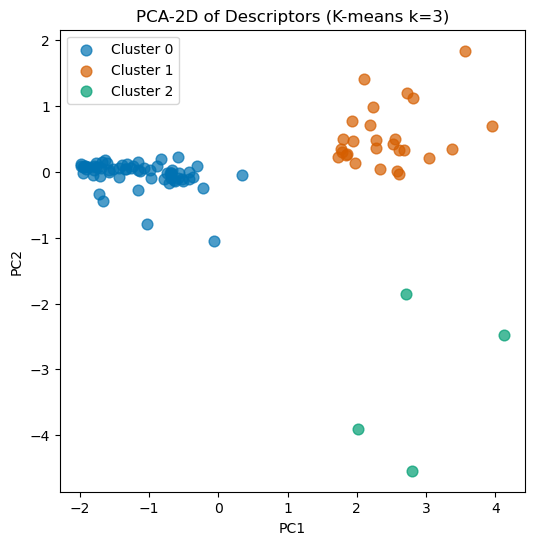

In [70]:
# Cluster your descriptors with k = 3 

# Standardize the descriptor matrix
X = StandardScaler().fit_transform(df_var.values)

# 1) Silhouette sweep (optional, to confirm k=3 is good)
print("K-means silhouette scores:")
for k in (2, 3, 4, 5):
    labels = KMeans(n_clusters=k, random_state=0).fit_predict(X)
    print(f"  k={k}: {silhouette_score(X, labels):.3f}")

# 2) Fit K-means with k = 3
k_final = 3
df['km3'] = KMeans(n_clusters=k_final, random_state=0).fit_predict(X)

print("\nCluster counts (k=3):")
print(df['km3'].value_counts().sort_index())

# 3) PCA → 2D projection for visualization
coords = PCA(n_components=2).fit_transform(X)
# define one colour per cluster label (0,1,2)
cluster_colors = [
    "#0072B2",  # blue
    "#D55E00",  # vermillion (orange-red)
    "#009E73",  # bluish-green
]
plt.figure(figsize=(6,6))
for lbl in sorted(df['km3'].unique()):
    idx = df['km3'] == lbl
    plt.scatter(
        coords[idx,0], coords[idx,1],
        color=cluster_colors[lbl],  # <-- pick colour here
        label=f"Cluster {lbl}",
        s=60, alpha=0.7
    )
plt.legend()
plt.title(f"PCA-2D of Descriptors (K-means k={k_final})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [71]:
from sklearn.metrics import pairwise_distances_argmin_min
centers = kmeans.cluster_centers_
dists, _ = pairwise_distances_argmin_min(X_scaled, centers)
df['dist_to_centroid'] = dists


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 5 while Y.shape[1] == 24

In [73]:
# Compute per-cluster means for your 4 descriptors
cluster_props = df.groupby('km3')[
    ['centroid_mean','centroid_std','bandwidth_mean','rolloff_mean']
].mean()
print(cluster_props)

# Compute the range (max–min) of each descriptor across clusters
delta = cluster_props.max() - cluster_props.min()
print("Across-cluster spread:", delta.sort_values(ascending=False))


     centroid_mean  centroid_std  bandwidth_mean  rolloff_mean
km3                                                           
0      7195.821546   7606.956283     1838.275384  25791.092520
1      8133.760739   7434.527813     2924.399781  28674.654600
2      7601.829226   6749.179986     2797.443610  28357.990896
Across-cluster spread: rolloff_mean      2883.562081
bandwidth_mean    1086.124396
centroid_mean      937.939194
centroid_std       857.776297
dtype: float64


In [74]:
from sklearn.ensemble import RandomForestClassifier

# use your 4-D descriptors as X
X = df[['centroid_mean','centroid_std','bandwidth_mean','rolloff_mean']].values
y = df['km3'].values

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X, y)

importances = rf.feature_importances_
for name, imp in zip(['centroid_mean','centroid_std','bandwidth_mean','rolloff_mean'], importances):
    print(f"{name}: {imp:.3f}")


centroid_mean: 0.252
centroid_std: 0.085
bandwidth_mean: 0.233
rolloff_mean: 0.431


Cluster means:
      centroid_mean  centroid_std  bandwidth_mean  rolloff_mean
km3                                                           
0      7195.821546   7606.956283     1838.275384  25791.092520
1      8133.760739   7434.527813     2924.399781  28674.654600
2      7601.829226   6749.179986     2797.443610  28357.990896 

Across-cluster spread:
 centroid_mean      937.939194
centroid_std       857.776297
bandwidth_mean    1086.124396
rolloff_mean      2883.562081
dtype: float64 



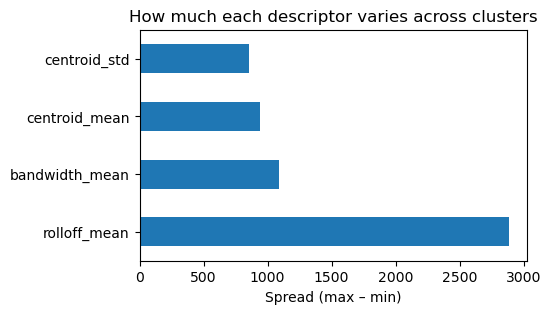

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# assume `df` has your four descriptors + `km3` cluster labels
descr = ['centroid_mean','centroid_std','bandwidth_mean','rolloff_mean']

# 1) Compute per-cluster means
cluster_means = df.groupby('km3')[descr].mean()
print("Cluster means:\n", cluster_means, "\n")

# 2) Compute the across-cluster spread (max–min) for each descriptor
spread = cluster_means.max() - cluster_means.min()
print("Across-cluster spread:\n", spread, "\n")

# 3) Bar-plot the spreads in descending order
spread.sort_values(ascending=False).plot.barh(figsize=(5,3))
plt.xlabel("Spread (max – min)")
plt.title("How much each descriptor varies across clusters")
plt.show()


Adjusted → center=383.2Hz, bw=119.1Hz, rolloff=1361.6Hz
Saved synthesized_wingbeat_continuous_adj.wav


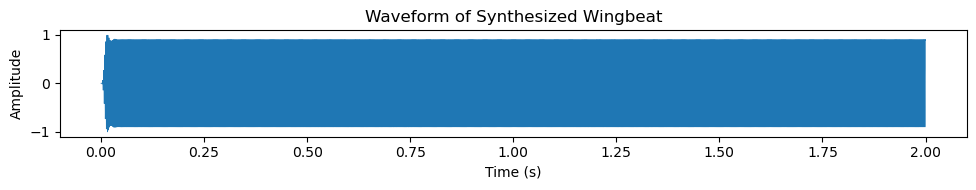

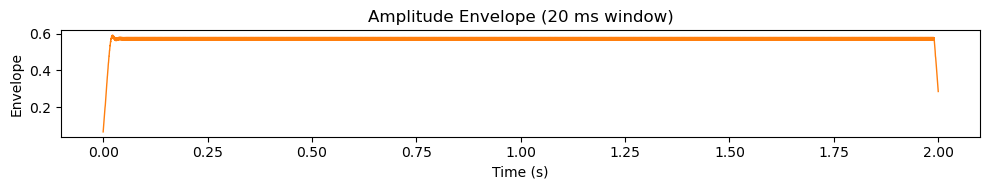

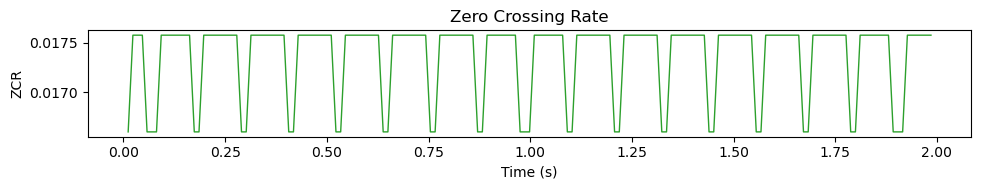

In [95]:
# %% [code]
### 9) Synthesize a continuous wingbeat‐like tone at 1/20 the original frequency
# (i.e. additional divide‐by‐2 to correct for doubling)

import numpy as np
import soundfile as sf
from scipy.signal import butter, sosfilt

# 1) Compute descriptor ranges (reuse df)
descr = ['centroid_mean','bandwidth_mean','rolloff_mean']
cluster_means = df.groupby('km3')[descr].mean()
min_vals = cluster_means.min()
max_vals = cluster_means.max()

# 2) Slider settings in [0,1]
S_roll, S_bw, S_cent = 0.5, 0.5, 0.5

# 3) Map sliders → actual descriptor values
rolloff = min_vals['rolloff_mean']   + S_roll*(max_vals['rolloff_mean']   - min_vals['rolloff_mean'])
bw      = min_vals['bandwidth_mean'] + S_bw*(max_vals['bandwidth_mean'] - min_vals['bandwidth_mean'])
center  = min_vals['centroid_mean']  + S_cent*(max_vals['centroid_mean']  - min_vals['centroid_mean'])

# 4) Down‐shift frequencies: original/10 then correct for doubling by /2 => total /20
center_adj  = center  / 20.0
bw_adj      = bw      / 20.0
rolloff_adj = rolloff / 20.0

print(f"Adjusted → center={center_adj:.1f}Hz, bw={bw_adj:.1f}Hz, rolloff={rolloff_adj:.1f}Hz")

# 5) Synthesis settings
sr  = 44100         # standard audio rate (Nyquist >> rolloff_adj)
dur = 2.0           # seconds
t   = np.linspace(0, dur, int(sr*dur), endpoint=False)

# 6) Generate pure sine wave at adjusted 'center' frequency
y = np.sin(2 * np.pi * center_adj * t)

# 7) Band‐pass around [center_adj – bw_adj/2, center_adj + bw_adj/2]
low  = max(center_adj - bw_adj/2, 1.0)
high = min(center_adj + bw_adj/2, sr/2 - 1.0)
sos_bp = butter(4, [low, high], btype='bandpass', fs=sr, output='sos')
y = sosfilt(sos_bp, y)

# 8) Low‐pass at adjusted rolloff (so only below rolloff_adj passes)
rolloff_adj = min(rolloff_adj, 1000.0)  
sos_lp = butter(4, rolloff_adj, btype='lowpass', fs=sr, output='sos')
y = sosfilt(sos_lp, y)

# 9) Normalize & save
y /= np.max(np.abs(y))
sf.write("synthesized_wingbeat_continuous_adj.wav", y, sr)
print("Saved synthesized_wingbeat_continuous_adj.wav")

# --- assume this is at the end of your synthesis cell,
#     so `y` (the audio array) and `sr` (its samplerate) are defined ---

import numpy as np
import matplotlib.pyplot as plt

# 1) Time axis
t = np.arange(len(y)) / sr

# 2) Plot raw waveform
plt.figure(figsize=(10, 2))
plt.plot(t, y, linewidth=0.5)
plt.title("Waveform of Synthesized Wingbeat")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()

# 3) Amplitude envelope (20 ms moving average)
win_ms = 20
win_samps = int(sr * win_ms / 1000)
env = np.convolve(np.abs(y), np.ones(win_samps)/win_samps, mode='same')
plt.figure(figsize=(10, 2))
plt.plot(t, env, color='C1', linewidth=1.0)
plt.title(f"Amplitude Envelope ({win_ms} ms window)")
plt.xlabel("Time (s)")
plt.ylabel("Envelope")
plt.tight_layout()

# 4) Zero‐crossing rate (manual)
frame_len, hop = 1024, 512
n_frames = 1 + (len(y)-frame_len)//hop
zcr = []
times = []
for i in range(n_frames):
    start = i*hop
    frame = y[start:start+frame_len]
    # count crossings
    count = np.sum(frame[:-1]*frame[1:] < 0)
    zcr.append(count/frame_len)
    times.append((start + frame_len/2)/sr)
zcr = np.array(zcr)
times = np.array(times)

plt.figure(figsize=(10, 2))
plt.plot(times, zcr, color='C2', linewidth=1.0)
plt.title("Zero Crossing Rate")
plt.xlabel("Time (s)")
plt.ylabel("ZCR")
plt.tight_layout()

# 5) Spectrogram fo



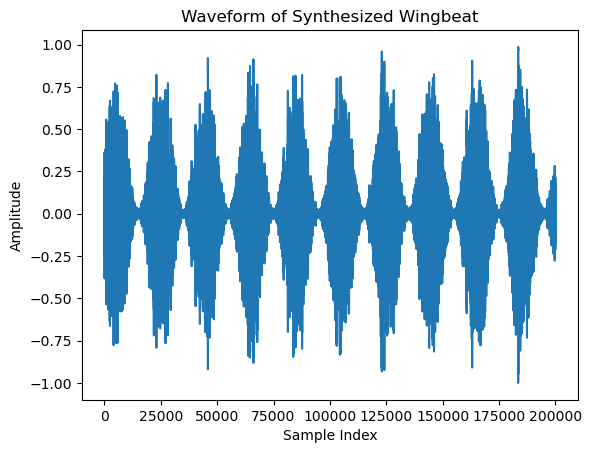

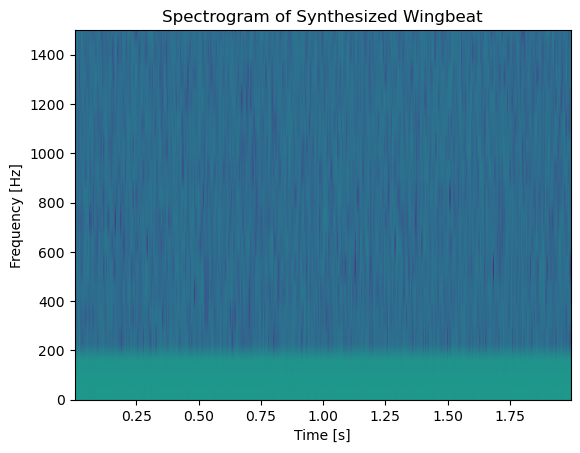

In [89]:
import soundfile as sf
import matplotlib.pyplot as plt

# Load the synthesized audio
y, sr = sf.read("synthesized_wingbeat.wav")

# Plot waveform
plt.figure()
plt.plot(y)
plt.title("Waveform of Synthesized Wingbeat")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

# Plot spectrogram
plt.figure()
plt.specgram(y, Fs=sr, NFFT=1024, noverlap=512)
plt.ylim(0,1500)   # zoom in below 1.5 kHz
plt.title("Spectrogram of Synthesized Wingbeat")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

plt.show()


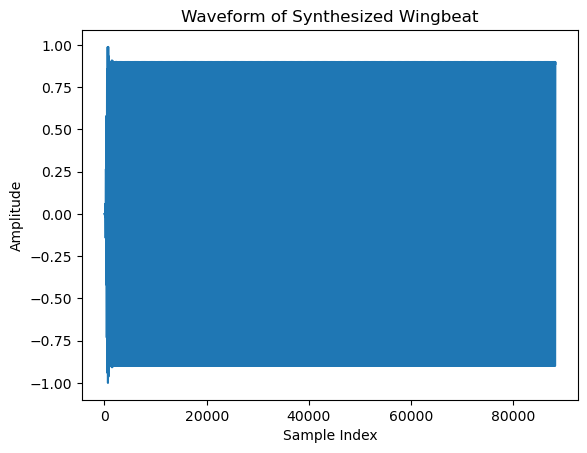

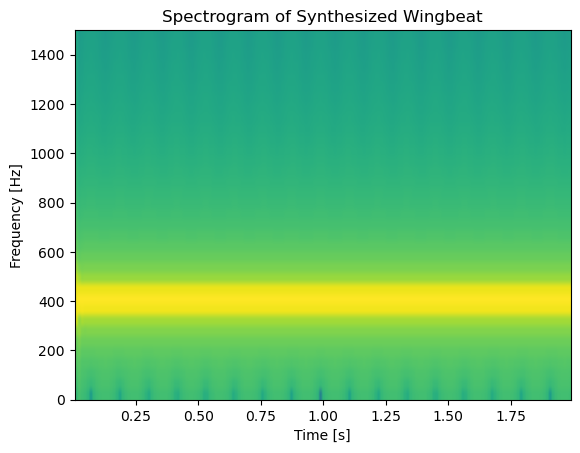

In [94]:
plt.figure()
plt.plot(y)
plt.title("Waveform of Synthesized Wingbeat")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

# Plot spectrogram
plt.figure()
plt.specgram(y, Fs=sr, NFFT=1024, noverlap=512)
plt.ylim(0,1500)   # zoom in below 1.5 kHz
plt.title("Spectrogram of Synthesized Wingbeat")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

plt.show()